<a href="https://colab.research.google.com/github/megha-puthukudi/main-project/blob/InceptionResNet50/inceptionresenet_learning_rate_change_better_one.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Found 1050 images belonging to 3 classes.
Found 235 images belonging to 3 classes.
Found 225 images belonging to 3 classes.
Epoch 1/10
65/65 [==============================] - 51s 609ms/step - loss: 1.2268 - accuracy: 0.3191 - val_loss: 1.1076 - val_accuracy: 0.4286
Epoch 2/10
65/65 [==============================] - 33s 511ms/step - loss: 1.2079 - accuracy: 0.3520 - val_loss: 1.0946 - val_accuracy: 0.4196
Epoch 3/10
65/65 [==============================] - 32s 494ms/step - loss: 1.1901 - accuracy: 0.3462 - val_loss: 1.0685 - val_accuracy: 0.4911
Epoch 4/10
65/65 [==============================] - 33s 505ms/step - loss: 1.1813 - accuracy: 0.3491 - val_loss: 1.0538 - val_accuracy: 0.4955
Epoch 5/10
65/65 [==============================] - 33s 500ms/step - loss: 1.1443 - accuracy: 0.3936 - val_loss: 1.0262 - val_accuracy: 0.5402
Epoch 6/10
65/65 [==============================] - 33s 510ms/step - loss: 1.1549 - accuracy: 0.3665 - val_loss: 0.9925 - val_accuracy: 0.5714
Epoch 7/10
65/65 [

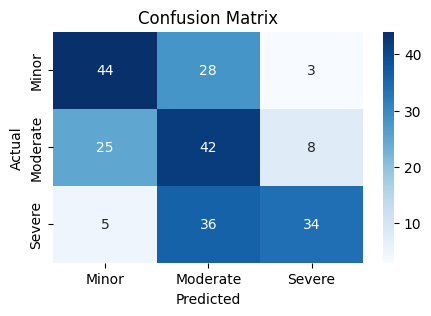

Test loss: 0.9666
Test accuracy: 53.12
Train loss: 0.9704
Train accuracy: 55.77
Recall: 0.53
Precision: 0.58
F1-score: 0.54


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
import seaborn as sns

# Define your data directories
train_dir = '/content/drive/MyDrive/severe ince/train'
val_dir = '/content/drive/MyDrive/severe ince/validation'
test_dir = '/content/drive/MyDrive/severe ince/test'

# Define image size and batch size
img_size = (299, 299)  # Adjusted for InceptionResNetV2
batch_size = 16

# Create data generators
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load the pre-trained InceptionResNetV2 model
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

# Add a global average pooling layer and a dense layer for classification
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)  # Adding dropout for regularization
predictions = Dense(3, activation='softmax')(x)  # Assuming 3 classes

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers in the base model except the last few
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.000001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=10,  # Increase number of epochs
    validation_data=val_generator,
    validation_steps=val_generator.n // batch_size
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.n // batch_size)
train_loss, train_accuracy = model.evaluate(train_generator, steps=train_generator.n // batch_size)

# Calculate recall, precision, and F1-score
y_true = []
y_pred = []
for _ in range(len(test_generator)):
    batch_x, batch_y = next(test_generator)
    y_true.extend(np.argmax(batch_y, axis=1))
    y_pred.extend(np.argmax(model.predict(batch_x), axis=1))

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Minor', 'Moderate', 'Severe'], yticklabels=['Minor', 'Moderate', 'Severe'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate other metrics
recall = recall_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Display metrics
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_accuracy * 100:.2f}')
print(f'Train loss: {train_loss:.4f}')
print(f'Train accuracy: {train_accuracy * 100:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1-score: {f1:.2f}')

# Save the trained model
model.save('/content/drive/MyDrive/colabtest/vecicle_damage_InceptionResNetV2_epoch_50_severity_ince.h5')


Saving p.jpg to p.jpg
1/1 [==============================] - 3s 3s/step


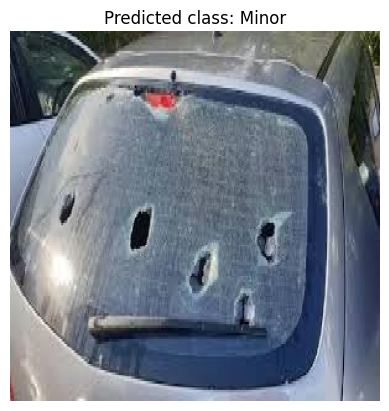

In [15]:
# Prediction section of car is damaged or Not damaged
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files

# Load the trained model
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/colabtest/vecicle_damage_InceptionResNetV2_epoch_50_severity_ince.h5')

# Define your class labels
class_labels = ['Minor', 'Moderate', 'Severe']

def predict_image(file_path):
    # Load the image from the specified file path and resize it to the target size of (224, 224)
    img = image.load_img(file_path, target_size=(299, 299))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    # Preprocess the input image using the preprocess_input function (specific to the model)
    processed_img = preprocess_input(img_array)
    # Use the loaded model to predict the class probabilities for the preprocessed image
    prediction = loaded_model.predict(processed_img)
    # Find the index of the class with the highest probability
    predicted_class_index = np.argmax(prediction)
    # Retrieve the corresponding class label from the class_labels list
    predicted_class_label = class_labels[predicted_class_index]

    return predicted_class_label, img

def select_image_and_predict():
    uploaded = files.upload()

    if uploaded:
        # Get the file path of the uploaded image
        file_path = list(uploaded.keys())[0]
        predicted_class, img = predict_image(file_path)    # Predict the class label and get the image
        plt.imshow(img)     # Display the image
        plt.axis('off')    # Turn off axis in the displayed image
        plt.title(f"Predicted class: {predicted_class}")
        plt.show()    # Show the plot with the image and title
    else:
        print("No file selected.")

# Call the function to select an image and make a prediction
select_image_and_predict()
